# Causal Tree

- Overview 
- Algorithm Description 
- The Algorithm in Action 
- What Comes Next? 
- References 

## Preliminaries

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from auxiliary import *

## Overview 

In this section of our student project we will elaborate further on the details of the Causal Tree algorithm. For a rigorous discussion one first needs to introduce the classical regression tree algorithm first proposed in [Breiman et al. 1984](https://books.google.de/books/about/Classification_and_Regression_Trees.html?id=JwQx-WOmSyQC&redir_esc=y) (see also [Hastie, Tibshirani and Friedman 2001](chrome-extension://nacjakoppgmdcpemlfnfegmlhipddanj/https://web.stanford.edu/~hastie/Papers/ESLII.pdf)). On this basis we will define in the subsection *Algorithm Description* the Causal Tree algorithm. This will be done by construction via listing exhaustively all places in the classical algorithm that need to be modified to arrive at the Causal Tree algorithm. Having gained some understanding of the inner workings of the algorithm we test its finite sample properties in the subsection *The Algorithm in Action*. At last we ask *What Comes Next?*, where we will talk about Causal Forests and even more sophisticated algorithms proposed in the recent literature. But first we must answer an even simpler question.

#### Why implement an algorithm yourself, if there already exists a good implementation? 

This question, already legitimate, gains even more weight by taking into account the amount of time it takes to write a fully-working implementation. This time cannot be used to read through the relevant economic literature or think about economic relationships per se. However, prominent economists with a strong computer science background, such as [Susan Athey](https://athey.people.stanford.edu/) and [Sendhil Mullainathan](https://www.chicagobooth.edu/faculty/directory/m/sendhil-mullainathan), show us that the time spent might be worthwhile. The approach praised in the machine learning community is quite clear about this: implement a working version of an algorithm once, as to understand **all** the details of it, then switch to an official library. Though answering the first question, this only defers the question to a new one: *Why do economists need to understand these algorithms in such detail?* A discussion on this questions is frequently brushed aside in lectures found at economics departments, as students are not expected to have the technical skills nor invest the needed time, which renders any discussion nonsensical anyways. But, researchers will certainly still know the answer: we are (usually) not interested in plain predictions or classifications alone, we are interested in answers to causal questions. If we formulate a query, say Q, and hope that our methods, algorithmic or not, give us an answer, say A, but in reality the method gives us the correct answer A' to the query Q', then we run the risks of mistaking A' for A. Therefore it is a necessity for the economic researcher to understand the methods she uses fully, such that the true answer mechanism is positively comprehended. Interesting examples of uncovering hidden mechanism of this sort are presented in recent papers by Sendhil Mullainathan, Jon Kleinberg and others (see e.g. [Discrimination in the Age of Algorithms](https://www.nber.org/papers/w25548)). 

## Algorithm Description

### Regression Tree Algorithm 

We consider the standard setting of observing a data sample $S = \{(y_i, X_i) \mid i = 1, \dots, n\}$, where $X_i = (x_{i1}, \dots, x_{iK}) \in \mathbb{R}^K$. Our goal is to fit a function to the data that describes the outcome variable $y_i$ conditional on observed characteristics $X_i$, for the given sample and for potentially new observation, respectively. Instead of modeling the function explicitly we follow the CART approach (see Breiman et. al above and below) to fit a tree-like structure to the data. More easily understood: we fit a (high-dimensional) finite-valued step function, where in each piecewise constant region the attained function value is simply the unconditional mean (of $y_i$) of training observations falling in this region. Hence, the algorithms only job is to find a *good* partition of the covariate space, henceforth denoted by $\mathbb{X}$. Let us further denote an arbitrary partition of $\mathbb{X}$ by 
$$\Pi := \{\ell_1, \dots, \ell_{\mid \Pi \mid} \} \,.$$
Then by definition of a partition $$\ell_i \subset \mathbb{X} \,, \,\, \cup_{i=1}^{\mid \Pi \mid} \ell_i = \mathbb{X} \text{ and } \ell_i \cap \ell_j = \emptyset \text{ for } i \neq j \,.$$
For notational ease let us define an index set containing indices of all observations falling in the same region as an arbitrary $x \in \mathbb{R}^K$, given some partition $\Pi$ and sample $S$. More formally, let
$$\mathcal{I}(x, \Pi, S) := \{i \mid X_i \in \ell(x; \Pi) \text{ and } (y_i, X_i) \in S \} \,,$$
where $\ell(x; \Pi) \in \Pi$ denotes the region of the partition in which $x$ falls. Once we constructed a partition $\Pi$, our outcome prediction function is simply given by 
$$\hat{\mu}(x; S, \Pi) := \frac{1}{\mid \mathcal{I}(x, \Pi, S) \mid} \sum_{i \in \mathcal{I}(x, \Pi, S)} y_i \,.$$
The reader should verify that this indeed defines a finite-valued step function. See figure 1 for an illustration of how a function of this form could look like. Note that restricting the function space to these simple functions is not necessarily prohibitive, as we know e.g. from the construction of various integrals in mathematics, that nearly arbitrary functions can be approximated by (limits of) step functions. Additionally, it is easy to see that under mild conditions on $\Pi_n$ and the conditional expectation 
$$\hat{\mu}(x, S_n, \Pi_n) \overset{P}{\longrightarrow} \mathbb{E}(y_i \mid X_i = x) \,,$$ where $S_n$ and $\Pi_n$ are naturally denoting a growing sample and a partition (allowed to change in $n$), respectively.

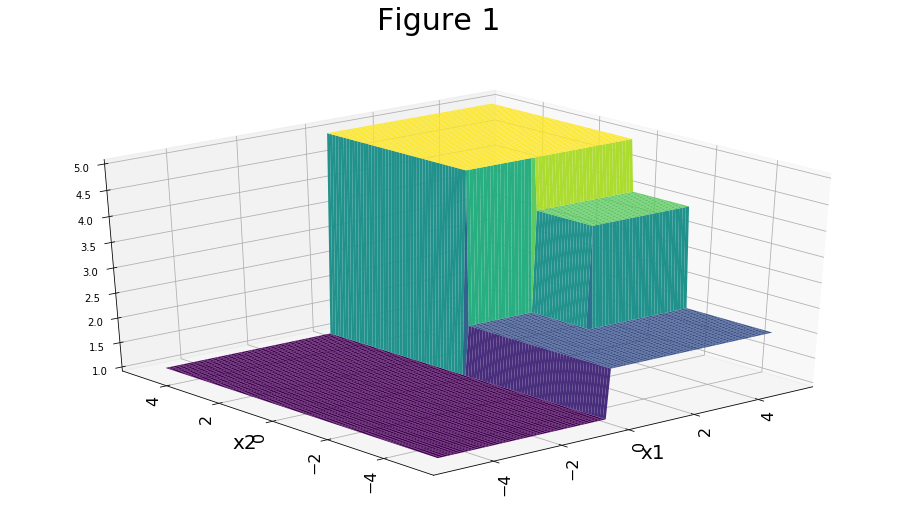

In [27]:
plot_figure1(width=16, height=8)

Let us now consider what it means to be a *good* partition in this (regression) context. In the direct comparison of multiple partitions $\{\Pi_1, \dots, \Pi_m\}$ we prefer the one that produces the smallest expected prediction error (mean squared error). That is, for a given training data sample $S_{train}$ and new data point $(y_j, X_j)$ following the same data generating process, the optimal partition $\Pi^*$ should be such that
$$\mathbb{E}\left(\left(y_j - \hat{\mu}(X_j; S_{train}, \Pi^*) \right)^2 \right)$$
is minimal. Of course naively searching through the partition space (hereafter just $\mathbb{P}$) is infeasible, as the number of potential partitions explodes for continuous covariates. This is where the regression tree algorithm comes in place which is, bluntly speaking, just a function $$\pi_{tree} : \mathbb{S} \longrightarrow \mathbb{P}$$ minimizing the above criterion, where $\mathbb{S}$ denotes the data-sample space. To overcome the problem of looking through too many potential partitions, the algorithm restricts attention only to a small subset of partitions. 
To be more precise, the algorithm searches for each covariate through all observed data points and estimates the loss that would occur if it would split the space by orthogonally cutting the axis (currently) under inspection at the specific data point it is looking at. The covariate (axis) and data point leading to the lowest loss will be chosen for the split to occur. After the first split took place the algorithm is applied to each of the two resulting subspaces independently. This (binary) splitting process is then applied recursively until some stopping criterion is reached. It should be clear that such a binary splitting process leads to a partition consisting of (potentially high-dimensional) rectangles. 

Consider again figure 1, but now think of it as representing the regions constructed by the algorithm. In the first iteration the space was split on the first axis ($x_1$) at exactly zero. In the next iteration the left subspace was not split and the right subspace was split at the point $x_2 = 0$, etcetera. Now compare this to figure 2, representing the same information in a tree-like structure. 

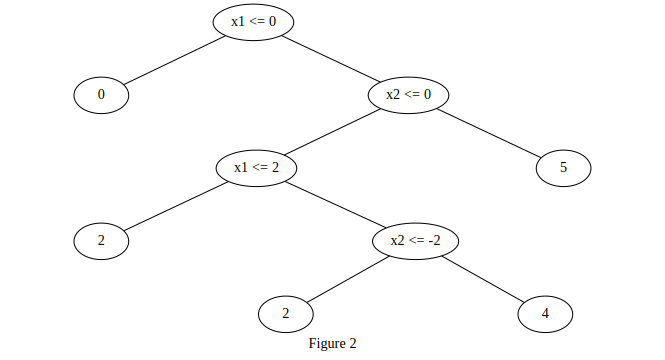

In [2]:
plot_figure2(ratio=.5, width=10, height=5)

The resulting regions $\ell \in \pi_{tree}(S)$ will be called leafs from here on. Two common stopping criteria are restricting the tree depth, i.e. number of iterations of applying the process, and minimal leaf size, that is, restricting the minimum number of observations that must be contained in a single leaf. The statistically inclined reader will quickly realize that a larger tree size (and smaller leaf size for that matter) can lead to dramatic overfitting and high variance estimators. However, going against first intuition, the solution to this problem is not cross-validating over the hyper-parameter space. It turns out that the most efficient method is given by growing very deep trees with small leaf sizes and then applying a specific pruning process, in which parts of the tree are cut off. Loosely speaking, the pruning algorithm considers a sequence of relevant subtrees and evaluates (via cross-validation) the explained variance of each subtree, while also adding a penalty for tree size to the overall estimated loss of a specific subtree. In comparison to tree-fitting, tree-pruning is vastly more complex, even relying on certain theorems to hold. This is why we will not explain the process any further (the interested reader should visit [Right Sized Tree via Pruning](https://newonlinecourses.science.psu.edu/stat508/lesson/11/11.8)). 

Summarizing, the regression tree algorithm aims to find a partition of the covariate space that minimizes the variance of outcomes in the resulting leafs. This is done by clustering observations with similar outcomes using a recursive binary splitting rule. 

### Causal Tree

Now that we know how to predict outcomes, can we exploit the above algorithm to predict (possibly heterogeneous) treatment effects? In fact, the answer depends heavily on what assumption the researcher is willing to make; however, under the following assumption it is yes. Our succeeding notations follows the classical Neyman-Rubin potential outcome framework, where $D_i$ denotes binary treatment assignment. We also expect that our data sample is now given by $S = \{(y_i, D_i, X_i) \mid i = 1, \dots, n \}$.

1. Assumption (Unconfoundedness) 
$$ D_i \perp\!\!\perp \bigl (Y_i(0), Y_i(1) \bigr) \mid X_i \,,$$
that is, we assume treatment assignment and potential outcomes being independent conditional on observed characteristics. Note that this already prohibits naive application to many interesting treatment effect estimation problems &mdash;algorithmic complexity does *not* magically settle issues such as dealing with relevant unobserved characteristics. 

2. Assumption (Overlapping)
$$\eta < \text{P}(D_i = 1 \mid X_i=x)< 1-\eta \enspace \forall x \in \mathbb{R}^K \enspace \text{for some} \enspace 0<\eta<1 \enspace \lambda-\text{almost everywhere}\,,$$
where $\text{P}$ denotes the underlying probability measure and $\lambda$ the $K$ dimensional Lebesgue measure. That is, we assume that in almost every region of the support of our (random) covariate vector we find treated and untreated observations. 

The object of our interest is the conditional average treatment effect, i.e. the difference in potential outcomes conditional on the features. In particular, let us define this effect by 
$$ \tau (x) := \mathbb{E}\bigl(Y_i(1) - Y_i(0) \mid X_i = x \bigr ) \,.$$
Similar as above, consider the index set 
$$\mathcal{J}(x, d, \Pi, S) := \{i \mid X_i \in \ell(x; \Pi) \text{ and } D_i = d \text{ and } (y_i, X_i) \in S \} \,,$$
where we extend $\mathcal{I}$ from above by adding a condition on the treatment status. Using our knowledge from above, instead of searching for a partition in which outcomes are similar among regions, we seek to find regions such that conditional treatment effects are homogeneous among clusters. Given we have found such a partition, say $\Pi$, we approximate $\tau$ by 
$$\hat{\tau}(x; S, \Pi) = \frac{1}{\mid \mathcal{J}(x, 1, \Pi, S) \mid} \sum_{j \in \mathcal{J}(x, 1, \Pi, S)} y_j - \frac{1}{\mid \mathcal{J}(x, 0, \Pi, S) \mid} \sum_{j \in \mathcal{J}(x, 0, \Pi, S)} y_j \,,$$
which again describes a finite-valued step function. Analogously, under very mellow conditions 
$$\hat{\tau}(x; S_n, \Pi_n) \overset{P}{\longrightarrow} \tau(x) \,.$$
The previous statements sound very promising, in that we can leverage the ability of tree algorithms to find appropriate partitions, in which we will then predict constant treatment effects by the above formula. But we must not forget how the classical algorithm evaluates its loss: it computes the sum of individual (squared) distances of  predictions $\hat{\mu}(X_i, S, \Pi)$ and (realized) outcomes $y_i$. However, we clearly do not observe individual treatment effects, which goes at the heart of the potential outcome problem: in practice only **one** of the potential outcomes is ever realized. Therefore if we aim at using the tree algorithm we must rely on (asymptotic) theory to guide as in finding a (pre-)estimate of individual treatment effects. First we define the propensity score function $p(x) := \mathbb{E}(D_i \mid X_i = x)$. Now consider the 
transformed outcome 
$$y_i^* := 
\begin{cases}
\frac{y_i}{p(X_i)}  \quad \text{, if } D_i = 1 \\
\frac{-y_i}{1 - p(X_i)}  \,\, \text{, if } D_i = 0
\end{cases} \,.
$$
Then, obviously $$\mathbb{E}(y_i^*) = \mathbb{E}(\tau_i) := \mathbb{E}\bigl(Y_i(1) - Y_i(0)\bigr) \,.$$ The propensity score function can naturally be estimated using traditional methods providing us with a valid first step of estimating the individual treatment effects. It should also be clear to the reader that these individual estimators are inherently seized with high variance, such that concentrating on simple functions in the post-estimation process will usually immensely decrease mean squared error.

To leave no questions open, the causal tree algorithm $\pi_{causal}: \mathbb{S} \longrightarrow \mathbb{P}$ consequently works analogously to the regression tree algorithm with only two exceptions. First, predictions are given by $\hat{\tau}\bigl(x; S_{tr}, \pi_{causal}(S_{tr})\bigr)$.
And second, the metric to compare partitions is given by
$$\mathbb{E}\left(\left[y_j^* - \hat{\tau}\bigl(X_j; S_{tr}, \pi_{causal}(S_{tr})\bigr) \right]^2 \right) \,,$$
where $S_{tr}$ denotes some training data sample.


Athey and Wager (2018) consider asymptotic properties of the causal forest algorithm; see below for reference. Causal Forests are the natural extension to Causal Trees given by the extension from decision trees to random forests. For these Causal Forests they have managed to show that the treatment effect estimator is asymptotically normal distributed under certain conditions. 

Furthermore, the mindful reader might have noticed the slight deviation to the standard notation used in statistical learning theory. Here we have taken extraordinarily care of indicating in each function, by using it as an argument, which data sample was used. The main reason we chose to pursue this notational path is consistency, as it is the same notation used in Athey and Imbens (2016). In their setting this is necessary since they also propose a splitting-rule, named *Honest Splitting*, based on a testing, training **and** estimation data sample. The advantages of this notation are seen when describing for example the observed test sample loss where estimations take place on an estimation data set and partition forming on a training data set, i.e.  $$ \sum_{(y_i, X_i, D_i) \in S_{test}} \bigg ( y_i^* - \hat{\tau} \big (X_i; S_{est}, \pi_{causal}(S_{train}) \big ) \bigg )^2 \,.$$ 

## The Algorithm in Action 
In this section we put our Causal Tree implementation to the test. At first we consider a basic data set containing 2 covariates. Then we use the more complex data set used in the project folder **Simulation Study** to benchmark the prediction capabilities of our implementation against *OLS*, *KNN* and the official *Generalized Random Forest* Package.

In [3]:
import pandas as pd
from collections import OrderedDict
from sklearn.model_selection import train_test_split

import readline 
import rpy2.rinterface
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
pandas2ri.activate()

from CausalTree import *

%run ./datasets/simulate_treatment_data.py


%load_ext rpy2.ipython

### Simple Data Generating Process 

Figure 3 displays the conditional treatment effect function. Here the $x_1$-$x_2$-Plane is simply split into its four quadrants. In the first quadrant the treatment effect is given by 0, in the second by 2, in the third by 14 and at last by -5 in the fourth quadrant. Next we simulate data on the given DGP and fit our Causal Tree implementation to it using its K-Fold cross validation pruning method. 

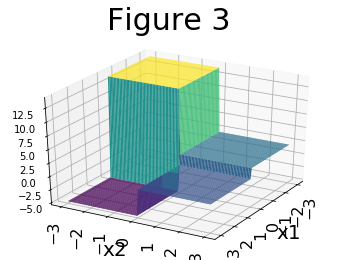

In [4]:
plot_figure3(width=16, height=8, view_x = 30, view_y=30)

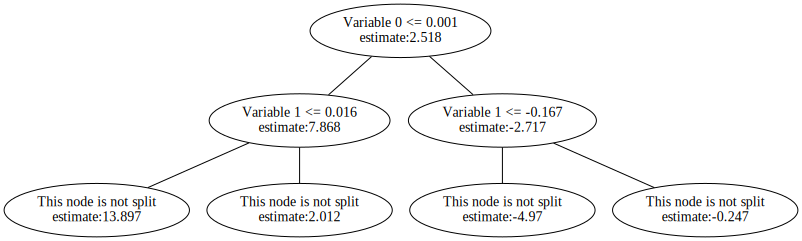

In [5]:
X, y, D = simulate_treatment_data(agents=1000, noise=True)  
# with noise set to True we add an error term to each observation 

tree_sparse, tree_opt = CausalTree.apply_kFold_CV(X, y, D, k=5, sparsity_bias=0.75) 
# since this method applies cross validation the complete process can take up to a few minutes to run

tree_sparse.plot()

We observe that in this simple example the Causal Tree works exactly as expected and splits the plane into the four correct regions. On top of that its predictions in each quadrant are also very close to the true parameters. Although the displayed tree is the sparser version of the one actually selected by cross validation. In some cases the *optimal* tree can still be very deep and we prefer a sparser model expecting it do be more general. This sparsity-biased selection process is known as the *one-standard-error rule* in statistical learning.

### Data Generating Process From Simulation Study 

In this subsection we consider the more involved data generating process presented, in more detail, in the folder **Simulation Study**. The conditional treatment effect function is displayed in figure 4. In comparison to the function above, the function in figure 4 is smooth and can therefore never be completely estimated by trees in finite samples. However, we see that there are many flat regions. We would hope to see that the Causal Tree splits the $x_1$ and $x_2$ axis at roughly 1/3 and estimates 0, 2 and 4 in the resulting regions.

Below we simulate the data using an R script, which also computes the estimates for KNN and OLS, as well as the generalized random forest (grf). Since the folder **Simulation Study** contains a complete monte-carlo-simulation, we will only consider a single draw as to check if the Causal Tree implementation can match up to the grf package. 

Here we draw from $n=1000$ agents and use $K=20$ covariates from which only the first two are relevant. We expect to see that the 18 irrelevant covariates are not considered in the splits. In particular we expect the tree to split at $x_i = \frac{1}3$ for a fixed $i \in \{1, 2\}$ and then in each of the resulting regions split again at $x_j = \frac{1}3$ for $j \in \{1, 2\}$ but $j \neq i$. See folder **Simulation Study** for a more thorough presentation of this data set. 

For some unknown reason we experienced weird behavior of the Causal Tree pruning algorithm with this particular data set. That is why here we will only use the standard fitting function on the given data set and then cut off all nodes that are located at a level deeper than two, since theoretically we expect that the data set can be optimally partitioned with two cuts. By simply cutting off all deep layers we essentially force the tree model to be sparser. We will see that in the current setting this approach makes the Causal Tree perform almost as good as the grf. Unfortunately in a real world scenario we would not know at which layer to cut; however, since ultimately we are interested in Causal Forest algorithms (see reference below as well as last subsection), which do *not* rely on the pruning process, this problem might *not* be of interest, as long as it actually stems from the pruning process. 

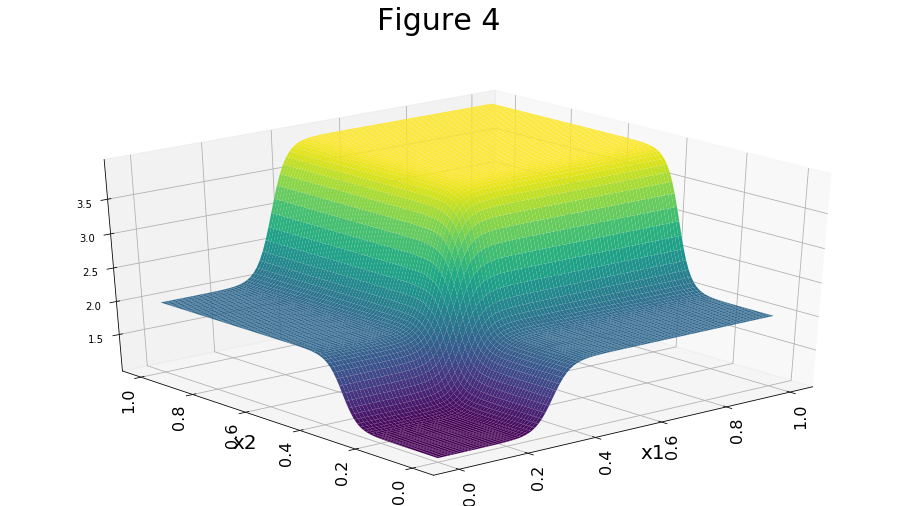

In [6]:
plot_figure4(width=16, height=8, view_x = 30, view_y=230, smoothness=40)

#### Simulate Data

In [7]:
%%R
# read in necessary packages
pack <- c("tidyverse","plyr", "dplyr", "FNN", "modelr", "rpart", "doParallel", "grf")
invisible(suppressMessages(suppressWarnings(lapply(pack, require, character.only = TRUE))))

# load relevant functions
source("datasets/simAW.R")

# set parameter values
n  <- 1000 # number of observations
K  <- 20 # number of covariates 
kC <- 20 # number of nearest neighbors (for knn) 

# simulate data 
r_df <- simAW(n, kC, K, sd=sqrt(.5), smoothness=40)

train_ind  <- sample(seq_len(n), size = floor(.7 * n))
r_df_train <- r_df[train_ind, ]
r_df_test  <- r_df[-train_ind, ]

# compute cate using grf
allX <- grep("^[X]", names(r_df_train), value = TRUE)
cf <- grf::causal_forest(X = as.matrix(r_df_train[, allX]), 
                         Y = as.matrix(r_df_train$Y_obs),
                         W = as.matrix(r_df_train$D),
                         num.trees = 100,
                         num.threads = 1,
                         honesty = FALSE)
        
cf_pred <- predict(cf, as.matrix(r_df_test[, allX]))  
# predictions of causal forest on testing data
cf_mse <- sum((r_df_test$CATE- cf_pred)^2) / nrow(r_df_test) 
# mean squared error of causal forest on testing data 

#### Convert R Objects to Python Objects

In [8]:
r_df_train = ro.r('r_df_train')
r_df_test = ro.r('r_df_test')
r_mse_grf = ro.r('cf_mse')
K = ro.r('K')
with localconverter(ro.default_converter + pandas2ri.converter):
    df_train = ro.conversion.rpy2py(r_df_train)
    df_test = ro.conversion.rpy2py(r_df_test)
    mse_grf = ro.conversion.rpy2py(r_mse_grf)
    K = int(ro.conversion.rpy2py(K))

df_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,I19,I20,D,Y0,Y1,Y_obs,tauhatknn,vartauhatknn,Cate_ols,CATE
1,0.198568,0.333481,0.065279,0.370285,0.578195,0.689496,0.924936,0.629767,0.132886,0.452081,...,0.000000,0.000000,0,-1.524489,0.886956,-1.524489,1.978794,0.014472,1.286734,1.508292
2,0.456157,0.693664,0.185340,0.512758,0.474188,0.958023,0.871263,0.929743,0.379708,0.112412,...,0.000000,0.000000,0,-1.304086,1.820686,-1.304086,3.134303,0.014472,2.856866,3.985404
3,0.054676,0.279131,0.600369,0.393733,0.648847,0.881381,0.530797,0.591344,0.545394,0.709759,...,0.000000,0.000000,0,-2.230482,0.527610,-2.230482,2.264148,0.014472,1.294247,1.102667
4,0.283432,0.825836,0.143385,0.238190,0.023001,0.313945,0.256063,0.092492,0.173752,0.411283,...,0.000000,0.000000,0,-1.289103,0.754360,-1.289103,2.727576,0.014472,3.059443,2.239236
5,0.986202,0.847341,0.267637,0.868368,0.180634,0.283172,0.556372,0.213022,0.590206,0.924762,...,0.306742,0.791896,1,-2.501507,2.630479,2.630479,3.820586,0.014472,4.717634,4.000000


#### Construct Training and Testing Data Set and Fit Causal Tree

In [9]:
X_test = df_test.iloc[:, 0:K].copy()

y_train = df_train['Y_obs'].copy()
X_train = df_train.iloc[:, 0:K].copy()
D_train = df_train['D'].copy()

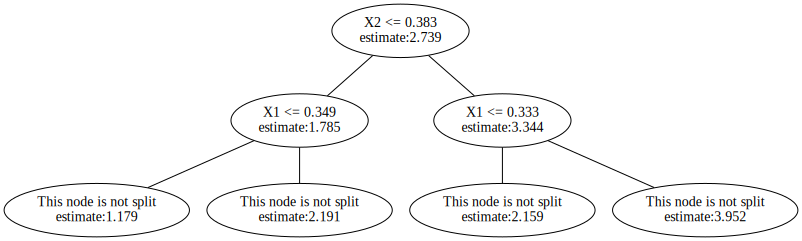

In [10]:
ctree = CausalTree()
ctree.fit(X_train, y_train, D_train)

node_list = CausalTree.get_level_in_list(ctree, 2) # returns all nodes 
# in the second layer 
for node in node_list:
    node.left_child = None
    node.right_child = None
    
ctree.plot()

As expected, the Causal Tree finds the correct splitting points, ignores the irrelevant covariates (at least in the first two splits) and estimates the conditional treatment effects fairly accurate. Furthermore, we see in the table below a comparison of mean squared error on testing data of the methods KNN, OLS, GRF and Causal Tree. Here our Causal Tree algorithm implementation is clearly better than KNN and OLS and performs in the range of the generalized random forest. 

#### Compare Mean Squared Error of Methods

In [11]:
tau_hat_causal_tree = ctree.predict(X_test) # applying the predict function to 
# new testing data on fitted Causal Tree

tau_hat_knn = df_test['tauhatknn'].values
tau_hat_ols = df_test['Cate_ols'].values
tau_real = df_test['CATE'].values

tau_hat_dict = OrderedDict()
tau_hat_dict["knn"] = tau_hat_knn
tau_hat_dict["ols"] = tau_hat_ols,
tau_hat_dict["causal_tree"] = tau_hat_causal_tree

mse_dict = OrderedDict()
mse_dict['grf'] = float(mse_grf)

for key, value in tau_hat_dict.items():
    mse_dict[key] = ((tau_real - value) ** 2).mean()
    
mse_df = pd.DataFrame.from_dict(dict(mse_dict), orient='index')
mse_df.columns = ['mse']
mse_df.T

,grf,knn,ols,causal_tree
mse,0.083876,0.652804,0.39441,0.08007


## What Comes Next? 

It was seen that the simple causal tree algorithm performs very well in our examples. Still, the next question should always be: Can we do better? The answer of course being: Yes! Nowadays regression tree algorithms usually operate only as the building blocks for more complex algorithms, as for instance the popular random forest algorithm or gradient boosting. These more complex algorithms can (more or less) trivially be extended to account for treatment effect estimation by letting them run on causal trees instead of regular trees. See for example the software package [*Generalized Random Forests*](https://github.com/grf-labs/grf) corresponding to the same-titled paper *Generalized Random Forests* (Athey, Wager, Tibshirani 2016), which includes the causal forest algorithm. 

Going one step further we might be interested in leveraging even more powerful algorithms. New accomplishments in computer vision, computational linguistics or (narrow) artificial intelligence in general, all depend in parts on algorithms related to (deep) neural networks. One of those algorithms, *Generative Adversarial Networks*, proposed 2014 in the same-titled paper by Goodfellow et al., achieves especially notably results. See for example figure 3, which shows [Edmond de Belamy](https://en.wikipedia.org/wiki/Edmond_de_Belamy), a painting constructed solely by a trained generative adversarial network. 

<figure>
<img src="https://upload.wikimedia.org/wikipedia/commons/c/c1/Edmond_de_Belamy.png" width="400" height="200" />
    <figcaption>Figure 3</figcaption>
</figure>

In 2018 Goudet et al. published their paper *Causal Generative Neural Networks*, exploiting the above mentioned power for causal inference. All of this should motivate researches in the field of economics and causal inference. More is possible than ever thanks to recent advances in data science, however there are still massive loads of unanswered questions. Instead of letting pure data scientist out-compete economists in the public eye and therefore shape the discussion on (economic) data-analysis, econometricians could stop complaining about non-existent theoretical foundations but rather start catching up and collaborate to work on the missing parts relevant to their work. We might even find new interesting questions to ask. 

## References

* ***Recursive partitioning for heterogeneous causal effects;*** Athey and Imbens; (PNAS July 5, 2016 113 (27) 7353-7360; first published July 5, 2016)

* ***Discrimination in The Age of Algorithms;*** Kleinberg, Ludwig, Mullainathan, Sunstein; [(NBER Working Paper No. 25548 Issued in February 2019)](https://www.nber.org/papers/w25548)

* ***Classification and Regression Trees;*** Breiman, Friedman, Olshen and Stone; (Chapman and Hall, Wadsworth, New York; published 1984)

* ***The Elements of Statistical Learning;*** Hastie, Tibshirani and Friedman; (Springer Series in Statistics Springer New York Inc., New York, NY, USA, (2009))

* ***Course on Tree-based Methods;*** (PennState Eberly Collge of Science; https://newonlinecourses.science.psu.edu/stat508/)

* ***Estimation and Inference of Heterogeneous Treatment Effects using Random Forests;*** Wager and Athey; (American Statistical Association, Volume 113, 2018 - Issue 523; published 2018)


* ***Generalized Random Forests;*** Athey, Tibshirani, and Wager; (Ann. Statist.; Volume 47, Number 2 (2019), 1148-1178.) 

* ***Generalized Random Forests Github Repository;*** https://github.com/grf-labs/grf 

* ***Generative Adversial Networks;*** Goodfellow et al.; (2014, https://arxiv.org/abs/1406.2661 [stat.ML])

* ***Causal Generative Neural Networks;*** Goudet et al.; (2018, https://arxiv.org/abs/1711.08936v2 [stat.ML])